# Data Integrating
* Author: 고지형, [iloveslowfood](https://github.com/iloveslowfood)
* 크롤링한 데이터를 병합한다.


In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt

In [246]:
path_list = glob('../raw/meta_trend_data/elements/*')
temp = pd.Series(path_list).apply(lambda x: x.split('.csv')[0].split('\\')[-1])

trend = temp[temp.str.endswith('trend')].sort_values(ignore_index=True)
meta = temp[temp.str.endswith('meta')].sort_values(ignore_index=True)

unique_meta = set(meta.apply(lambda x: x.split('_meta')[0]))
unique_trend = set(trend.apply(lambda x: x.split('_trend')[0]))

well_defined = list(unique_meta.intersection(unique_trend))
len(well_defined)

364

In [247]:
integrated = pd.DataFrame()
for idx in range(len(well_defined)):
    srs = pd.Series(path_list)
    meta_path, trend_path = srs[srs.apply(lambda x: x.split('\\')[-1].startswith(well_defined[idx]))].tolist()
    
    meta, trend = pd.read_csv(meta_path), pd.read_csv(trend_path)
    if meta.shape[0] == 0 or trend.shape[0] == 0:
        continue
    meta = meta.sort_values(by='date', ignore_index=True).drop('thumbnail', axis=1)
    meta.rename({'view': 'video_n_view', 'subscribe':'current_cumul_subs', 
                 'total_cumul_view':'current_cumul_view', 'comment':'n_comment',
                'like': 'n_like', 'dislike':'n_dislike'}, axis=1, inplace=True)
    trend.rename({'view': 'daily_n_view', 'subscriber': 'cumul_subs'}, axis=1, inplace=True)

    result = trend.merge(meta, how='left', on='date')
    # 결측값 채울 수 있는 정보는 채움 & 기본 정보 추가
    result['current_cumul_view'] = meta['current_cumul_view'][0] # 누적 총 조회수
    result['current_cumul_subs'] = meta['current_cumul_subs'][0]
    result['sign_in'] = meta['sign_in'][0] # 가입일
    result['sign_in'] = result['sign_in'].apply(lambda x: x.replace('.', '-')[:-1])
    result['current_n_video'] = meta.shape[0] # 누적 업로드 영상 수
    result['channel'] = meta['channel'][0]

    col_order = ['channel', 'sign_in', 'date', 'title', 'genre', 'duration', 'video_n_view', 'description', 'n_comment',
     'n_like', 'n_dislike', 'daily_n_view', 'cumul_view', 'cumul_subs', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
    result = result[col_order]
    integrated = pd.concat([integrated, result], ignore_index=True, axis=0)

In [250]:
integrated.head(2)

,channel,sign_in,date,title,genre,duration,video_n_view,description,n_comment,n_like,n_dislike,daily_n_view,cumul_view,cumul_subs,current_cumul_view,current_n_video,current_cumul_subs
0,TWITCHFM,2019-8-23,2019-11-29,Топ Моменты с Twitch | Приготовила Огромную Пиццу,People & Blogs,8.25,22949.0,Топ Моменты с Твич | Топ Клипы с Twitch за Ноя...,53,1260.0,79.0,23300,46600,22799,30251480,422,119000
1,TWITCHFM,2019-8-23,2019-11-30,Топ Моменты с Twitch | Как Снимают Видео в Тик...,People & Blogs,7.80,22966.0,Топ Моменты с Твич | Топ Клипы с Twitch за Ноя...,26,1279.0,46.0,23300,69900,22799,30251480,422,119000


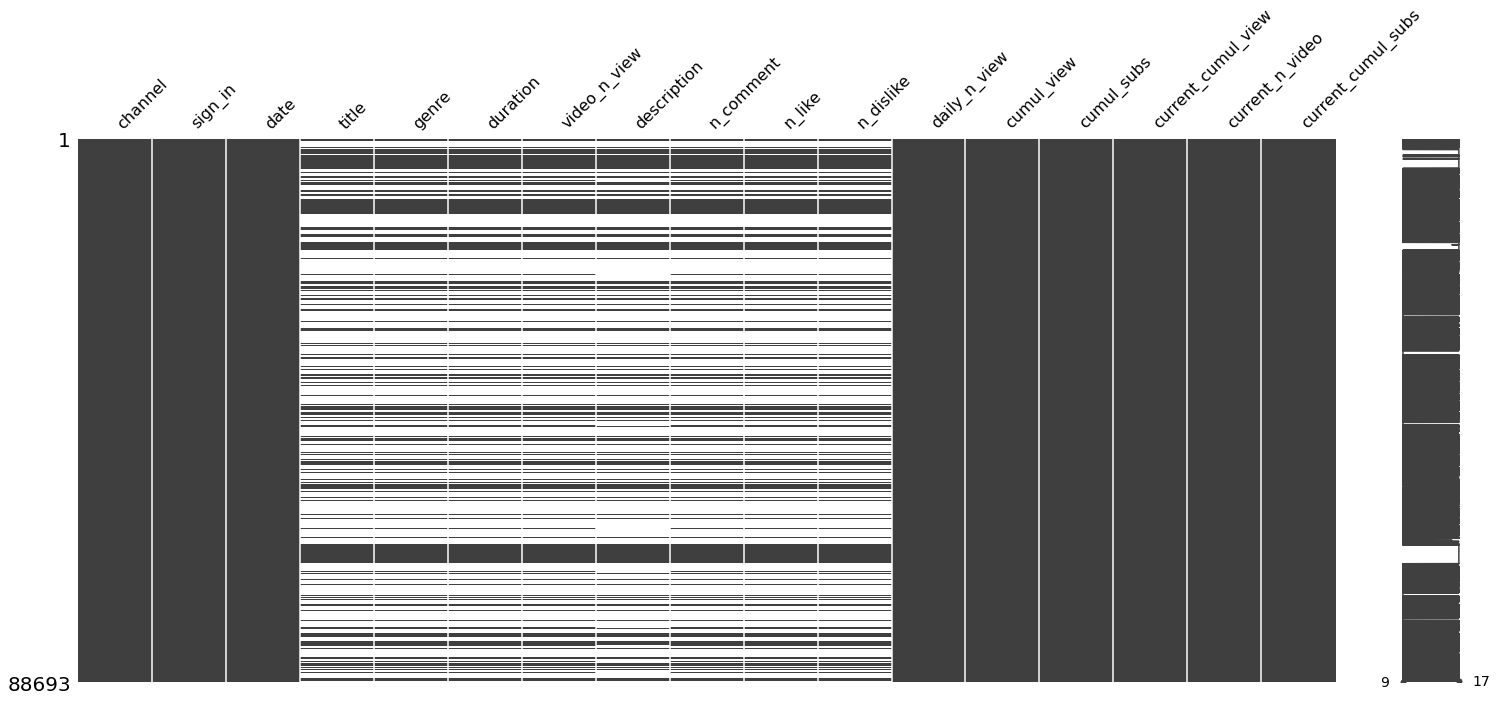

In [254]:
msno.matrix(integrated)
plt.show()

## Save

In [239]:
integrated.to_csv('meta_trend_data.csv', index=False)